In [34]:
import json
from pprint import pprint
from context_printer import ContextPrinter as Ctp
from src.metrics import BinaryClassificationResults
from src.print_util import print_rates
import matplotlib.pyplot as plt

Ctp.set_automatic_skip(True)

In [7]:
path_gs = 'grid_search_results/federated_classifiers/run_0/'
path_test = 'test_results/federated_classifiers/run_0/'

In [16]:
with open(path_gs + 'local_results.json') as json_file:
    local_results = json.load(json_file)
    
with open(path_gs + 'new_devices_results.json') as json_file:
    new_devices_results = json.load(json_file)

In [23]:
def get_round_results_sum(results):
    round_results_sum = []
    for configuration, configuration_results in results.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_results in enumerate(configuration_results):
            for federation_round, round_results in enumerate(fold_results):
                if federation_round >= len(round_results_sum):
                    round_results_sum.append(BinaryClassificationResults())  
                round_results_sum[federation_round] += BinaryClassificationResults(*round_results.values())
                
    return round_results_sum

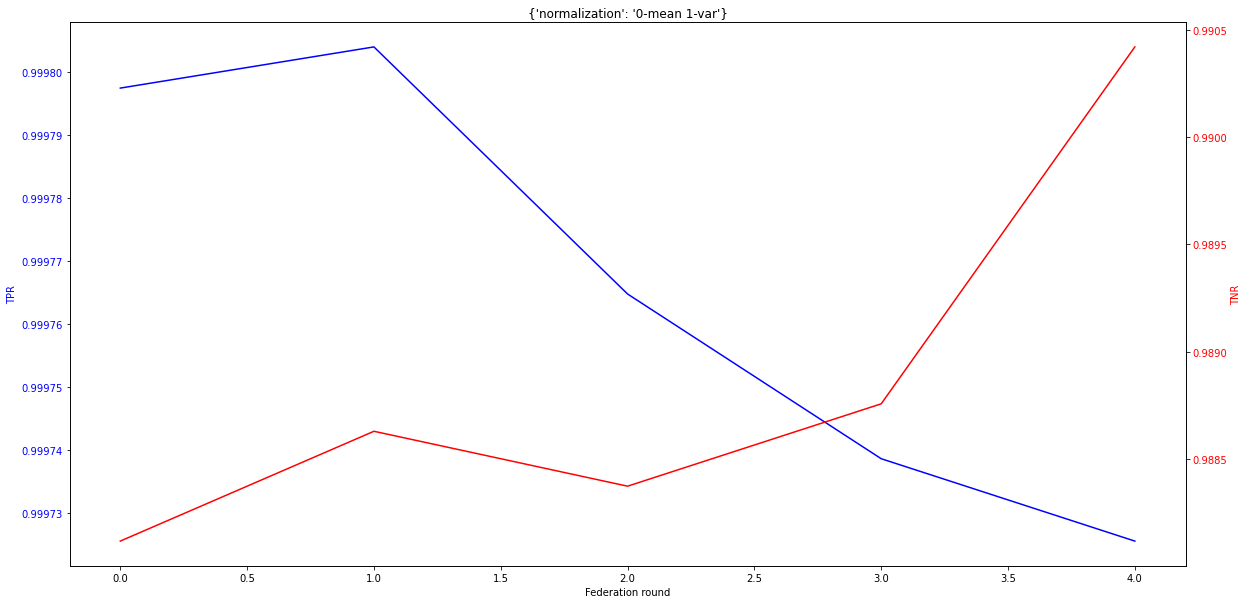

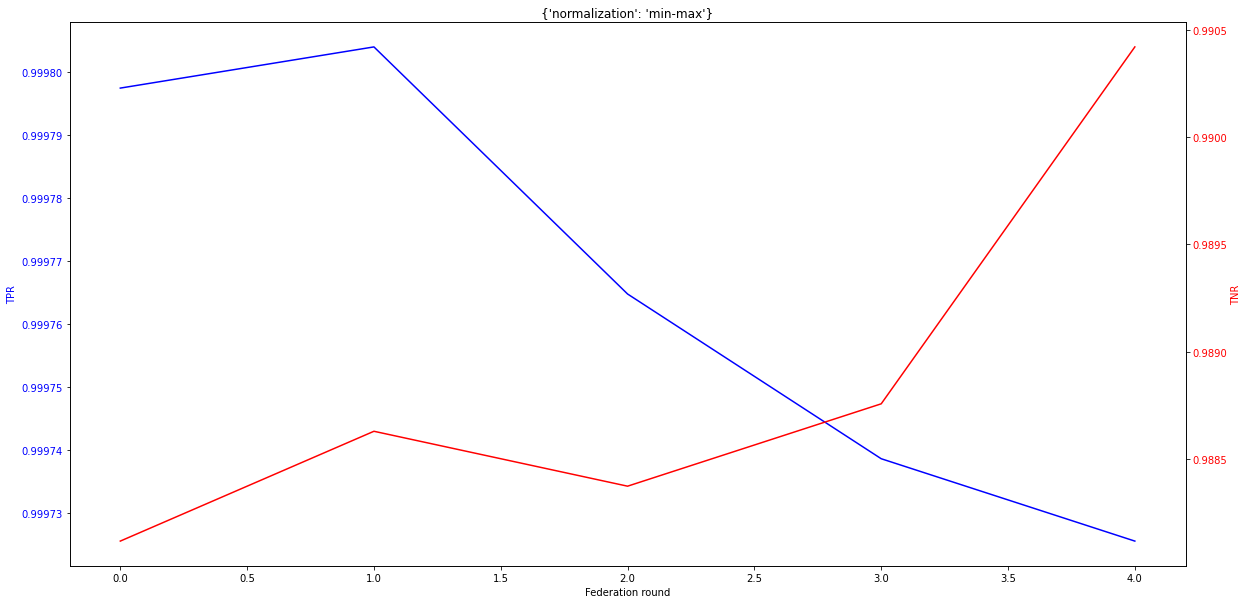

In [76]:
for params, experiment_results in local_results.items():
    round_results_sum = get_round_results_sum(experiment_results)
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax1.set_xlabel('Federation round')
    
    color = 'blue'
    ax1.set_title(params)
    ax1.set_ylabel('TPR', color=color)
    ax1.plot([result.tpr() for result in round_results_sum], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.ticklabel_format(useOffset=False)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('TNR', color=color)
    ax2.plot([result.tnr() for result in round_results_sum], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.show()

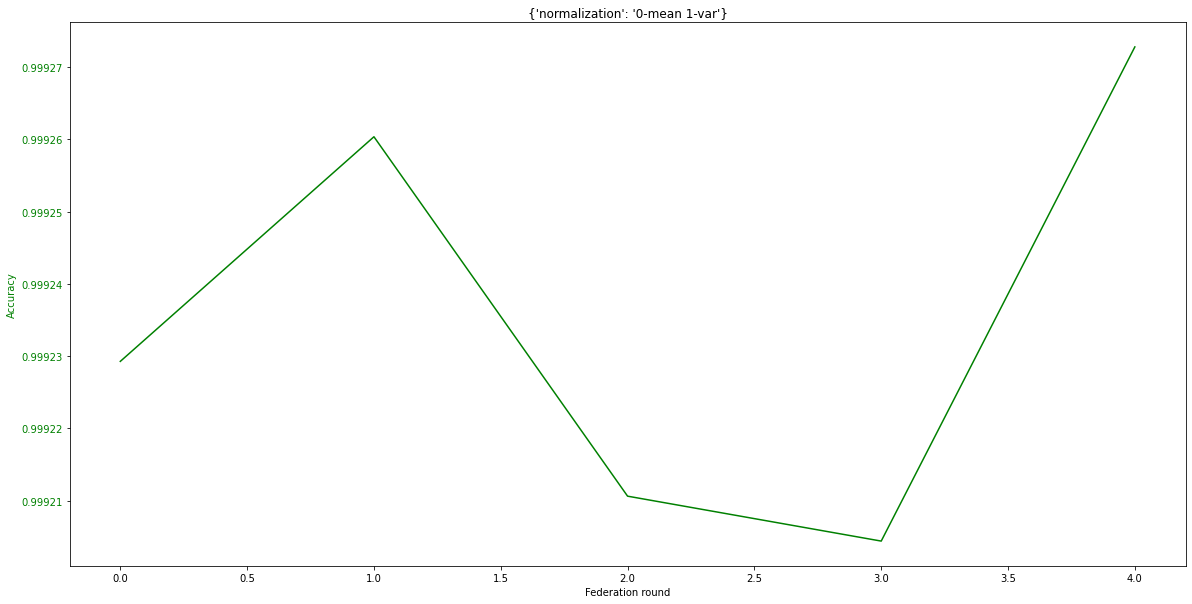

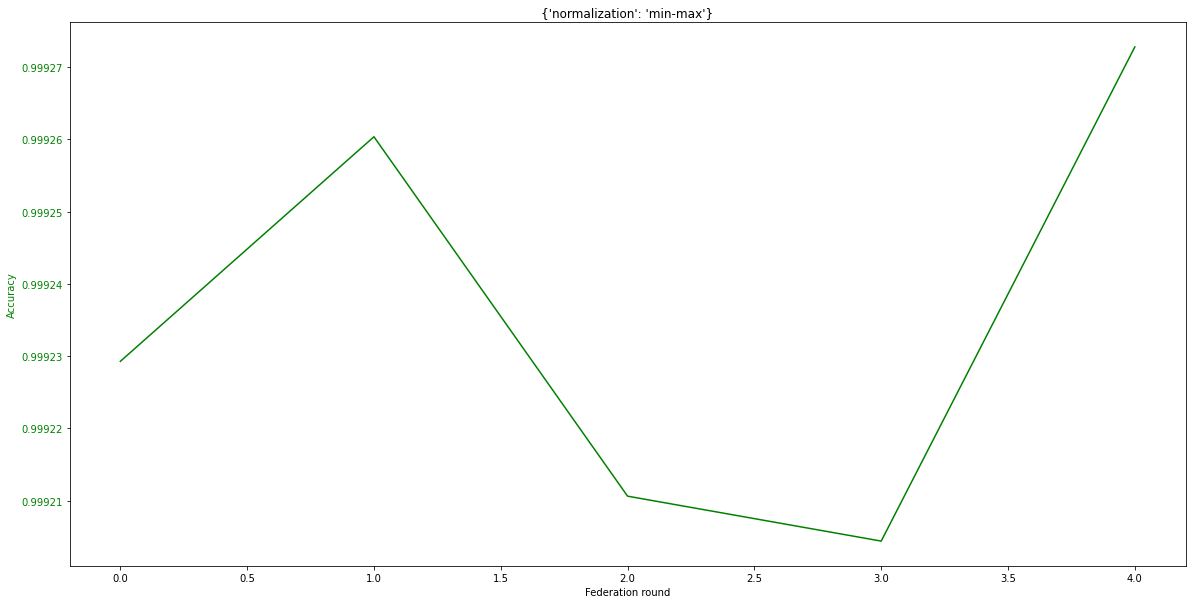

In [78]:
for params, experiment_results in local_results.items():
    round_results_sum = get_round_results_sum(experiment_results)
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlabel('Federation round')
    
    color = 'green'
    ax.set_title(params)
    ax.set_ylabel('Accuracy', color=color)
    ax.plot([result.acc() for result in round_results_sum], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    plt.show()

These plots are interesting but could be improved with: confidence intervals, more federation rounds, using test results instead of gs results, agreeing on a metric that takes into account the importance of tnr vs tpr, doing the same on new devices results.

In [19]:
experiment_local_results_sum = {}

for params, experiment_results in local_results.items():
    experiment_local_results_sum[params] = BinaryClassificationResults()
    for configuration, configuration_results in experiment_results.items():        
        for fold, fold_results in enumerate(configuration_results):
            last_round_results = fold_results[-1]
            experiment_local_results_sum[params] += BinaryClassificationResults(*last_round_results.values())    

In [21]:
experiment_new_devices_results_sum = {}

for params, experiment_results in new_devices_results.items():
    experiment_new_devices_results_sum[params] = BinaryClassificationResults()
    for configuration, configuration_results in experiment_results.items():        
        for fold, fold_results in enumerate(configuration_results):
            last_round_results = fold_results[-1]
            experiment_new_devices_results_sum[params] += BinaryClassificationResults(*last_round_results.values())  

In [20]:
for params, result in experiment_local_results_sum.items():
    Ctp.print(params)
    print_rates(result)
    Ctp.print()

{'normalization': '0-mean 1-var'}
TPR: 0.99976 - TNR: 0.93134 - Accuracy: 0.99438 - Recall:0.99976 - Precision: 0.99417 - F1-Score: 0.99696

{'normalization': 'min-max'}
TPR: 0.99967 - TNR: 0.98557 - Accuracy: 0.99856 - Recall:0.99967 - Precision: 0.99877 - F1-Score: 0.99922



In [22]:
for params, result in experiment_new_devices_results_sum.items():
    Ctp.print(params)
    print_rates(result)
    Ctp.print()

{'normalization': '0-mean 1-var'}
TPR: 0.99973 - TNR: 0.92597 - Accuracy: 0.99393 - Recall:0.99973 - Precision: 0.99371 - F1-Score: 0.99671

{'normalization': 'min-max'}
TPR: 0.99967 - TNR: 0.98414 - Accuracy: 0.99845 - Recall:0.99967 - Precision: 0.99865 - F1-Score: 0.99916



We can see that min-max normalization works much better. However we need to make that decision automatic based on a function of TPR local, TNR local, TPR new, TNR new.